# Importing libraries and data

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
csv_source = 'STC_set_data.csv'
#csv_source = 'https://raw.githubusercontent.com/Zorug/Steam-Stuff/master/STC_set_data.csv'
data_csv = pd.read_csv(csv_source)
qnt_data = data_csv.shape[0]
qnt_data

10587

In [3]:
data_csv.sample(2)

,Game,# Owned,# Unique,# Cards,Badge Lvl,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Emote Avg,BG Avg,Avg Qty,Discount,Added,AppId
7869,DARTHY,0,0,5,0,0.36,0.36,0.07,0.07,0.0,0.03,0.03,27,0.18,2015-12-06,404850
5218,Disgaea 2 PC,0,0,8,0,0.69,0.69,0.09,0.13,-44.4,0.06,0.14,155,0.31,2017-01-30,495280


# Organizing DataSet

## Cleaning Useless columns
This columns are useless for our analysis.

In [4]:
data_csv = data_csv.drop(['# Owned', '# Unique', 'Badge Lvl','Emote Avg', 'BG Avg', 'Discount', 'Added'], axis=1)
data_csv.sample(2)

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
1124,Lawless Lands,6,0.38,0.38,0.06,0.08,-33.3,20,880130
5904,Underground Keeper,6,0.44,0.44,0.07,0.31,-342.9,17,497040


## Type formatting
In here is important to change the type of the variables to work with it without errors.

In [5]:
pd.DataFrame(data_csv.dtypes).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
0,object,int64,object,object,float64,float64,object,int64,int64


In [6]:
def remove_missing_comma(byword): # here we are avoiding a conversion error
    byword = byword.replace(',','')
    return byword

to_float = ['Set Price', 'Price Diff', 'Booster %']
for column in data_csv[to_float]:
    data_csv[column] = data_csv[column].apply(remove_missing_comma)

data_csv[to_float] = data_csv[to_float].astype('float64')
data_csv['AppId'] = data_csv['AppId'].astype('str')

pd.DataFrame(data_csv.dtypes).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
0,object,int64,float64,float64,float64,float64,float64,int64,object


## Verify Missing Values

In [7]:
pd.DataFrame(data_csv.isna().sum()).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
0,1,0,0,0,0,956,0,0,0


### Working in the missing Game name

In [8]:
data_csv[data_csv.Game.isna() == True] # missing game name

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
4677,NaN,7,1.2,1.2,0.17,NaN,0.0,27,562280


Here we have a missing Game name, but we can find it by the AppId, adding at the end of this page: <p>https://www.steamcardexchange.net/index.php?gamepage-appid-562280

The game name is __\</reality>__, so we need to substitute it.

In [9]:
data_csv.at[4677,'Game'] = '</reality>'
pd.DataFrame(data_csv.loc[4677]).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
4677,</reality>,7,1.2,1.2,0.17,NaN,0.0,27,562280


In [10]:
pd.DataFrame(data_csv.isna().sum()).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
0,0,0,0,0,0,956,0,0,0


### Working in the missing Booster Avg data

_Booster Avg: The average price of a card from the set's booster;_ It's possible that they don't have any booster at the market.

In [11]:
print(f"the percentage of missing \'Booster Avg\' values is {round((956/qnt_data)*100,3)}%")

the percentage of missing 'Booster Avg' values is 9.03%


In any case, is better to maker a second dataframe dropping this missing values.

In [12]:
clean_data_csv = data_csv.dropna(axis = 0, how ='any')
pd.DataFrame(clean_data_csv.isna().sum()).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
0,0,0,0,0,0,0,0,0,0


## Little look at 'Booster %' column

In [13]:
clean_data_csv.sample(2)

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
8314,Shower With Your Dad Simulator 2015: Do You St...,6,0.41,0.41,0.07,0.05,28.6,394,359050
5172,Wacky Spores: The Chase,10,0.66,0.66,0.07,0.28,-300.0,20,582530


Let's make an exploratory dataframe for exploration than

In [14]:
exp_df = clean_data_csv[["Card Avg", "Booster Avg", "Booster %"]].copy()
exp_df['Bstr_Prp'] = exp_df['Booster %']/100 # proporção do %
exp_df['B/C'] = round(exp_df['Booster Avg']/exp_df['Card Avg'],3) # relation Booster/Card
exp_df.sample(2)

,Card Avg,Booster Avg,Booster %,Bstr_Prp,B/C
4552,0.05,0.04,20.0,0.20,0.80
2511,0.04,0.03,25.0,0.25,0.75


Here we see that the lower the value in B/C column, cheaper is the Card in the booster comparing with buying a card in the market. It's dificult to see it with this strange percentage in boster %, but the higher the percentage, it's more worth to buy the booster pack. But I prefere to see how much is the value of the Booster card, so I will create a new column for that:

In [15]:
exp_df['C/B'] = round(exp_df['Card Avg']/exp_df['Booster Avg'],3) # relation Card/Booster
exp_df.sample(2)

,Card Avg,Booster Avg,Booster %,Bstr_Prp,B/C,C/B
1823,0.08,0.08,0.0,0.00,1.00,1.000
9696,0.59,0.36,39.0,0.39,0.61,1.639


In [16]:
exp_df.sort_values(by=['C/B'], ascending=False).head(3)

,Card Avg,Booster Avg,Booster %,Bstr_Prp,B/C,C/B
995,0.20,0.00,100.0,1.000,0.000,inf
3480,77.81,1.08,98.6,0.986,0.014,72.046
4969,20.32,2.23,89.0,0.890,0.110,9.112


let's take a look in these booster costing zero:

In [17]:
pd.DataFrame(clean_data_csv.loc[995]).T

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
995,Lost Words: Beyond the Page,7,1.39,1.39,0.2,0.0,100.0,16,599610


In [18]:
clean_data_csv[clean_data_csv['Booster Avg'] == 0]

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
995,Lost Words: Beyond the Page,7,1.39,1.39,0.2,0.0,100.0,16,599610


As there is only one value with this error, it is interessant to remove it.

In [19]:
exp_df = exp_df.drop(995)
clean_data_csv = clean_data_csv.drop(995)

exp_df.sort_values(by=['C/B'], ascending=False).head()

,Card Avg,Booster Avg,Booster %,Bstr_Prp,B/C,C/B
3480,77.81,1.08,98.6,0.986,0.014,72.046
4969,20.32,2.23,89.0,0.890,0.110,9.112
6919,0.83,0.12,85.5,0.855,0.145,6.917
9433,0.32,0.05,84.4,0.844,0.156,6.400
6565,0.24,0.04,83.3,0.833,0.167,6.000


Now, we can add this easy to see proportion at our DataFrame:

In [20]:
clean_data_csv['Rate C/B'] = round(clean_data_csv['Card Avg']/clean_data_csv['Booster Avg'],3)
clean_data_csv.sample(2)

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId,Rate C/B
6495,Lolly Joe,5,1.33,1.33,0.27,0.29,-7.4,85,436060,0.931
3047,My Free Farm 2,5,0.79,0.79,0.16,0.77,-381.3,30,799240,0.208


# Verify Correlations
Here we can see how the data are related to each other

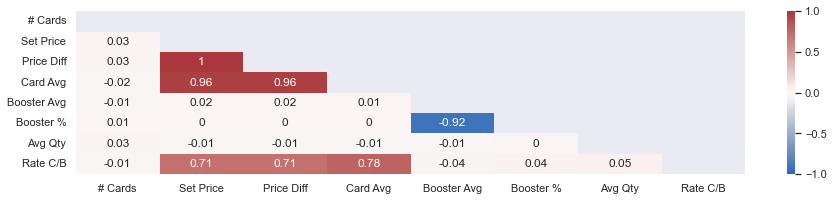

In [21]:
def correlation_heat(data_frame): # heatmap that shows the correlation between variables
    matrix = data_frame.corr().round(2)
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
    plt.show()
    
sns.set(rc={"figure.figsize":(15, 3)}) #set size of the sns image
correlation_heat(clean_data_csv)

The mean values of the variables are followed:

In [22]:
data_mean = clean_data_csv.copy()
data_mean.drop(['Game', 'AppId'], axis=1, inplace=True)
pd.DataFrame(round(data_mean.mean(),3)).T

,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,Rate C/B
0,7.155,0.678,0.678,0.1,0.435,-354.286,280.663,1.064


## Set Price __X__ Price Diff
- _Set Price - The total price of all the cards for the set_
- directly proportional
- correlation: 1
- mean relation: 0.678 X 0.678

Now, let's verify if this columns are equal:

In [23]:
test = clean_data_csv[['Set Price', 'Price Diff']].copy()
test['Difference'] = test['Set Price'] - test['Price Diff']
test.query('Difference != 0.0')

,Set Price,Price Diff,Difference


if there is no difference then they are the same

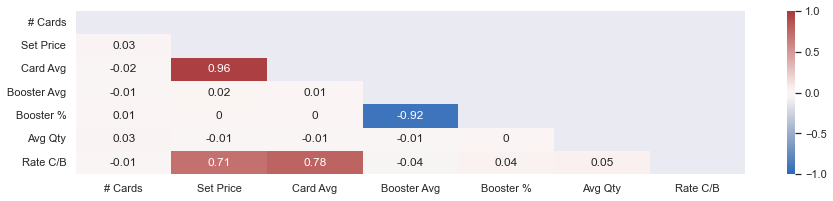

In [24]:
clean_data_csv = clean_data_csv.drop('Price Diff', axis=1)
correlation_heat(clean_data_csv)

## Set Price __X__ Card Avg
- _Card Avg - The total price of all the cards for the set_
- directly proportional
- correlation: 0.96
- mean relation: 0.678 x 0.1

In [25]:
print(f'The proportion between Set_Price and Card_Avg is: {0.678/0.1}')

The proportion between Set_Price and Card_Avg is: 6.78


__This result is pretty obvious as 'Card Avg' is the average value of each card in the set.__

## Booster % __X__ Booster Avg
- _Booster % - How many percent cheaper average booster cards are for the set;_
- _Booster Avg - The average price of a card from the set's booster;_
- inversely proportional
- correlation: -.92
- -354.239 x 0.435

__This result is expected as the rate on 'Booster %' grows as the 'Booster Avg' decreases__

# Individual Analysis of Each Column
Here we can get a better view of the total distribution

## '# Cards'

<AxesSubplot:xlabel='# Cards'>

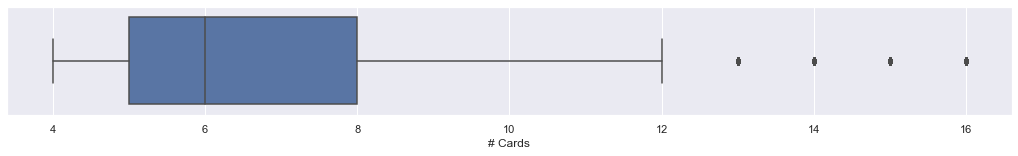

In [26]:
sns.set(rc={"figure.figsize":(18, 2)}) #set size of the sns image
sns.boxplot(x=clean_data_csv['# Cards'])

## 'Set Price'

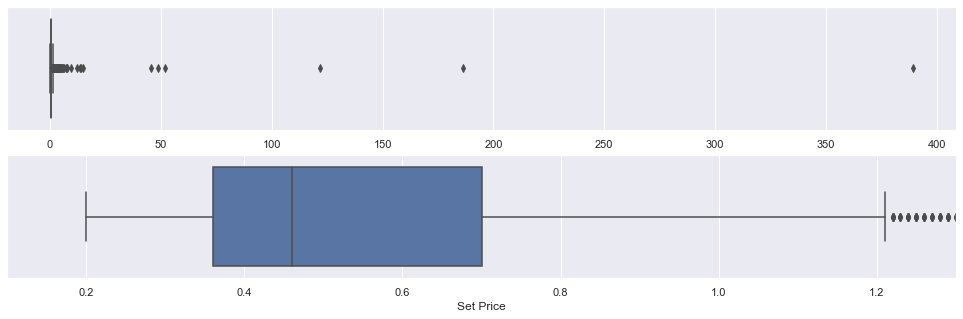

In [27]:
def boxwithzoom(column, min_limit, max_limit): # here is a standard function to create the plots with zoom
    f, axs = plt.subplots(2, 1, figsize=(17,5), sharey=True)
    ax1 = sns.boxplot(x=column, ax=axs[0])
    ax1.set(xlabel=None)
    ax2 = sns.boxplot(x=column, ax=axs[1])
    ax2.set_xlim([min_limit, max_limit])
    
boxwithzoom(clean_data_csv['Set Price'], 0.1, 1.3)

## 'Card Avg'

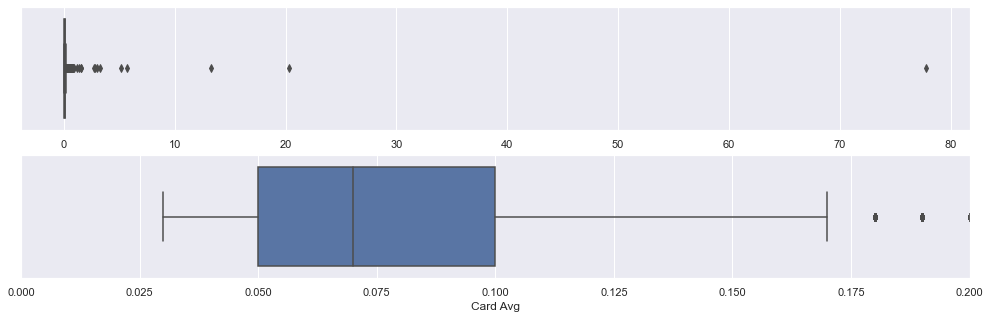

In [28]:
boxwithzoom(clean_data_csv['Card Avg'], 0, 0.2)

## 'Booster Avg'

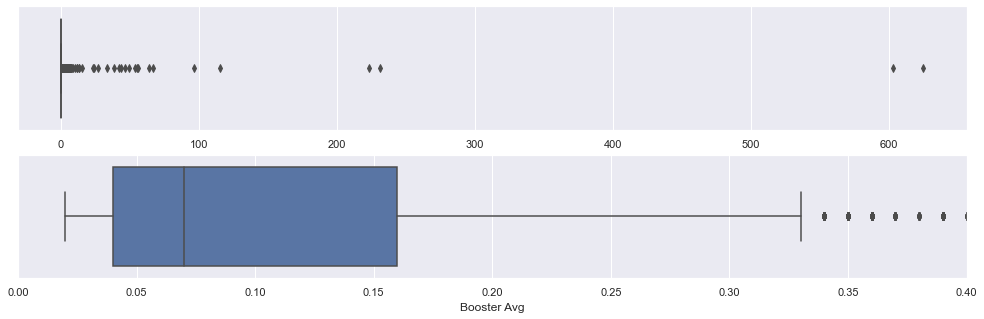

In [29]:
boxwithzoom(clean_data_csv['Booster Avg'], 0, 0.4)

## 'Booster %'

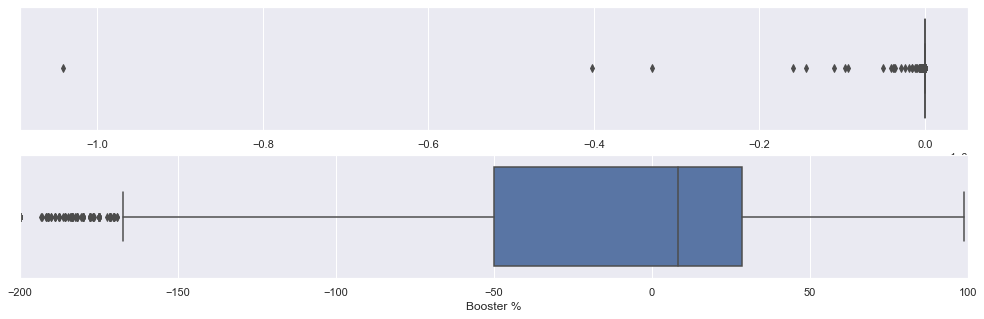

In [30]:
boxwithzoom(clean_data_csv['Booster %'], -200, 100)

## 'Avg Qty'

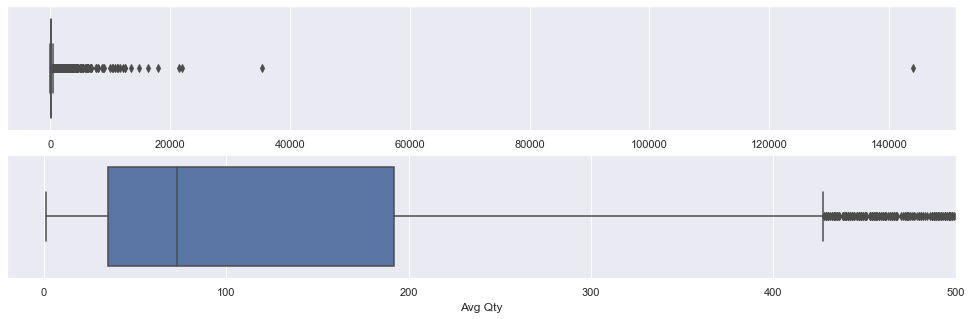

In [31]:
boxwithzoom(clean_data_csv['Avg Qty'], -20, 500)

## 'Rate C/B'

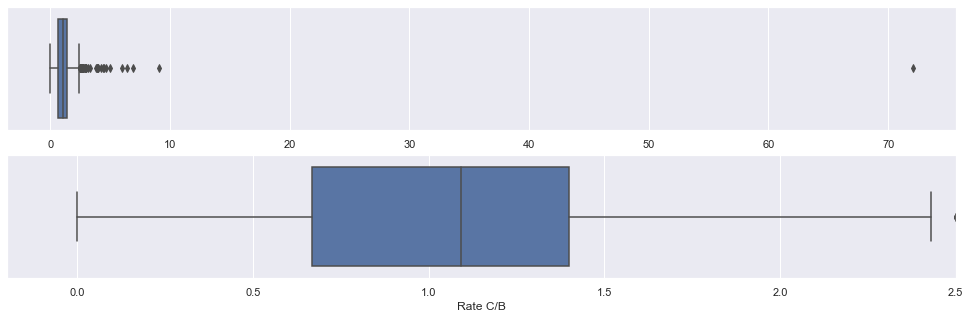

In [32]:
boxwithzoom(clean_data_csv['Rate C/B'], -0.2, 2.5)

# Conclusions

The purpose here is not just to understand but to prepare the DataSet in order to suggest booster purchases for the resale of individual cards. Some conclusions of this work are quite obvious, since many values of the columns of the original file are dependent variables.